<a href="https://colab.research.google.com/github/drdww/OPIM5641/blob/main/Module6/M6_1/2_Location_Problem_Advanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nonlinear Optimization: Warehouse Location (advanced)
**OPIM 5641: Business Decision Modeling - University of Connecticut**

Please refer to Powell Ch. 8 for more details and examples.

-----------------------------------------------

In [ ]:
%matplotlib inline
from pylab import *

import shutil
import sys
import os.path
import numpy as np

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("ipopt") or os.path.isfile("ipopt")):
    if "google.colab" in sys.modules:
        !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
        !unzip -o -q ipopt-linux64
        #!apt-get install -y -qq glpk-utils
    else:
        try:
            !conda install -c conda-forge ipopt
        except:
            pass

assert(shutil.which("ipopt") or os.path.isfile("ipopt"))

from pyomo.environ import *

***Location Problem (revisited).*** Return to the simple Kilroy Paper
Company example. Upon further
consideration, the logistics manager points out that the
trucks do not make an equal number of trips to the
various stores. Thus, a better proxy for total distribution
costs would be obtained by weighting the distance from 
distribution center to store k by the annual number of trips
to store $k$ (represented as $n_k$). The expanded set of input
data is as follows:

Site ($k$)| $x_k$| $y_k$| $n_k$
---|---|---|---
1| 5| 41| 12
2| 20| 10| 20
3| 44| 48| 15
4| 60| 58| 27
5| 100| 4| 8
6| 138| 80| 16
7| 150| 40| 10
8| 170| 18| 18
9| 182| 2| 25
10| 190| 56| 14

1. Find the optimal location for Kilroy’s distribution center in
this expanded version of the problem.
2. What is the optimal value of the objective function?

## Background (2D Distances)
*Same as before...*

**What is our objective?** To minimize this distance between the DC and the stores. We need to predict the XY coordinates of the DC.

What is a good measure of distance? The Euclidean distance formula.

For each store $k$, we can calculate the pairwise distance between the store and the DC.

$D_k(x,y) = \sqrt{(x-x_k)^2 + (y-y_k)^2}$

And we will repeat this 10 times (one for each store, DC pair) and try to minimize this quantity.

$f(x,y)=\Sigma_{k=1}^{10}D_k(x,y)$

*This is new...*
NOW! We have some more information here - the number of trips that each store requires. How do we handle this? Easy. Use the number of trips as a weight - this will force the model to prioritize it.

$f(x,y)=\Sigma_{k=1}^{10}D_k(x,y)*n_k$

where $n_k$ is the number of trips.

That's it! Now let's go build a model.

## Model Setup
As mentioned, our objective is to minimize the sum of the pairwise distance between stores.

$Min(\Sigma_{k=1}^{10}D_k(x,y)*n_k)$

You are just looking for the geographic centroid between the points as a function of the number of trips.

Let's see how to do this.

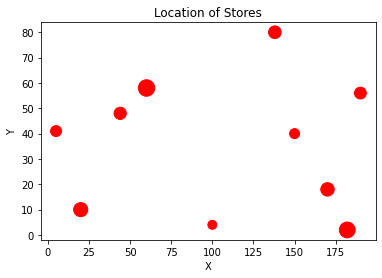

array([  5,  20,  44,  60, 100, 138, 150, 170, 182, 190])

In [ ]:
# specify X, Y and N coords of each store
import numpy as np
X = np.array([5, 20, 44, 60, 100, 138, 150, 170, 182, 190])
Y = np.array([41, 10, 48, 58, 4, 80, 40, 18, 2, 56])
N = np.array([12, 20, 15, 27, 8, 16, 10, 18, 25, 14])

# note how consistent we are with our naming convention...

# show a map!
from pylab import *
scatter(X,Y, s=N*10, color='red') # '.' plots them as dots on a scatterplot... as a function of size
title('Location of Stores') # here is the example: https://datavizpyr.com/make-bubble-plot-in-python-with-matplotlib/#:~:text=Bubble%20plot%20is%20a%20scatterplot,us%20load%20Pandas%20and%20Matplotlib.
xlabel('X')
ylabel('Y')
plt.show() # gets rid of annoying text

X

Looking at the above map, where would you put the dot? Might be easy if only 2D, but later on, we will get more sophisticated and add other criterion... more later...

In [ ]:
# this is the same as before

# declare the model
model = ConcreteModel()

# number of stores (there are 10)
n_points = len(X)

# declare decision variables
# remember, we need to intialize a value here (and try different ones)
model.Xcoord = Var(domain=Reals,bounds = (0,200), initialize=0)
model.Ycoord = Var(domain=Reals, bounds = (0,100), initialize=0)
# and this is to store the intermediate Distances as we try to find optimal Xcoord and Ycoord
model.Dist = Var([i for i in range(n_points)],domain=Reals, initialize=0)

model.pprint()

1 Set Declarations
    Dist_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   10 : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

3 Var Declarations
    Dist : Size=10, Index=Dist_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :  None :     0 :  None : False : False :  Reals
          1 :  None :     0 :  None : False : False :  Reals
          2 :  None :     0 :  None : False : False :  Reals
          3 :  None :     0 :  None : False : False :  Reals
          4 :  None :     0 :  None : False : False :  Reals
          5 :  None :     0 :  None : False : False :  Reals
          6 :  None :     0 :  None : False : False :  Reals
          7 :  None :     0 :  None : False : False :  Reals
          8 :  None :     0 :  None : False : False :  Reals
          9 :  None :     0 :  None : False : False :  Reals
    Xcoord : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : St

In [ ]:
# Constraints
model.constraints = ConstraintList()

# Pairwise values from DC to store (loops 10 times)
for i in range(n_points):
  x = X[i]
  y = Y[i]
  n = N[i]

  # notice how n makes an appearance now
  model.constraints.add(model.Dist[i] == n*((model.Xcoord-x)**2 + (model.Ycoord-y)**2)**0.5)

# declare objective
# we are trying to minimize the distance
obj_expr = 0 # intialize the objective as a 0...
for i in range(n_points):
  obj_expr += model.Dist[i]
model.error = Objective(
                      expr = obj_expr,
                      sense = minimize)

# show the model you've created
model.pprint()

2 Set Declarations
    Dist_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   10 : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
    constraints_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   10 : {1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

3 Var Declarations
    Dist : Size=10, Index=Dist_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :  None :     0 :  None : False : False :  Reals
          1 :  None :     0 :  None : False : False :  Reals
          2 :  None :     0 :  None : False : False :  Reals
          3 :  None :     0 :  None : False : False :  Reals
          4 :  None :     0 :  None : False : False :  Reals
          5 :  None :     0 :  None : False : False :  Reals
          6 :  None :     0 :  None : False : False :  Reals
          7 :  None :     0 :  None : False : False :  Reals
          8 :  None :  

Now let's run it!

In [ ]:
# solve it
SolverFactory('ipopt', executable='/content/ipopt').solve(model).write()
# show the results
print("Objective value = ", model.error())
print("Xcoord = ", model.Xcoord())
print("Ycoord = ", model.Ycoord())

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 10
  Number of variables: 12
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.12.13\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.017623424530029297
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
Obje

Great! Now show the map with your new Distribution Center (DC) on it!

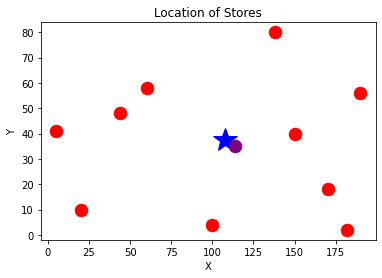

In [ ]:
# show a map!
from pylab import *
plot(X,Y, '.', markersize=25, color='red') # '.' plots them as dots on a scatterplot
title('Location of Stores')
xlabel('X')
ylabel('Y')
# let's add the new distribution as a big blue star
plot(model.Xcoord(),model.Ycoord(), '*', markersize=25, color='blue') # '.' plots them as dots on a scatterplot
# let's add the OLD ANSWER (approximate) as a purple dot
plot(114,35, '.', markersize=25, color='purple')
plt.show() # gets rid of annoying text

# On Your Own...
Now you know how to make it a function of number of visits! What other ideas do you have? 